# Zion Data Analysis Notebook

Defs, Imports, etc

In [16]:
import os, sys
from glob import glob
import time
from collections import UserDict, UserString
import numpy as np
import pandas as pd
from skimage.color import rgb2hsv
from skimage import filters, morphology, segmentation, measure
from scipy.optimize import nnls
from tifffile import imread, imwrite
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [11, 8]

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from image_processing.ZionImage import ZionImage, create_labeled_rois, get_wavelength_from_filename, get_cycle_from_filename, get_time_from_filename, get_imageset_from_cycle
from image_processing.ZionBase import df_cols, extract_spot_data, csv_to_data, crosstalk_correct, display_signals, create_phase_correct_matrix, base_call, add_basecall_result_to_dataframe


### Give the notebook a directory of tiffs to work in and some parameters:

In [17]:
input_dir_path = "G:\\.shortcut-targets-by-id\\1kVG9N507_FkwrDbPtbAUweyHCZc_ys7E\\Zion_Data\\MK27_02\\20230303_1536_S003_DV_MCPB003_0003\\raws1"

# This parameter determines whether temporal difference images are used
useDifferenceImage = False

# This is the name of the UV channel
uv_wl = "365"

# This determines what type of background subtraction is used
bgSubtract = False

useTiff = True

# This was used to help with file identification
#bTiff = False


## Step 1: Spot Detection

### Define parameters used in spot detection. 

When you run this cell, ROIs will be displayed. Verify you get the spots you want. (If not, adjust parameters here and re-run.)

Detecting ROIs using median=9, erode=25, dilate=19, scale=0.9
25 spot candidates found


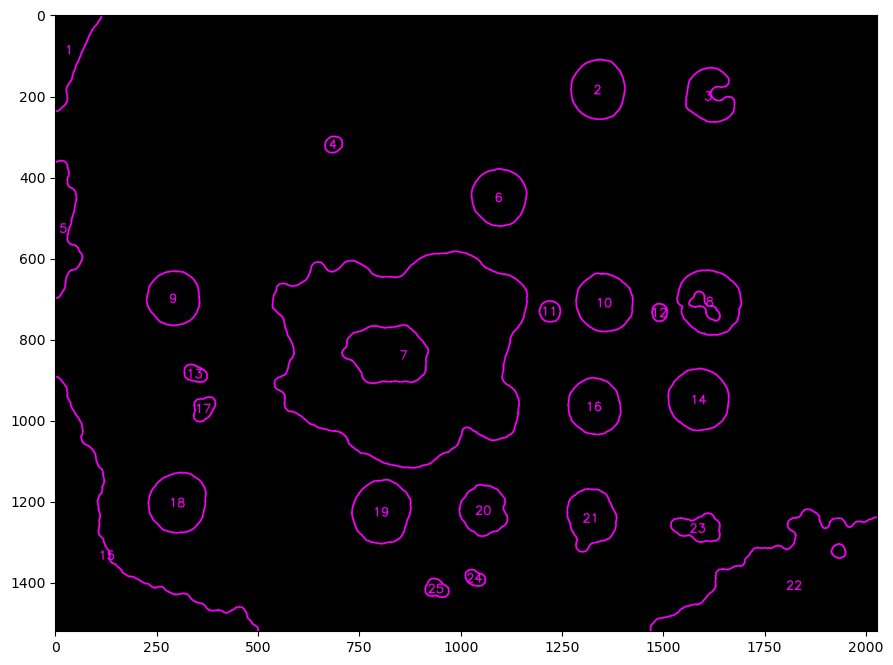

In [18]:
# This determines size of noise filter kernel (prob doesn't need to be changed much)
median_kernel_size = 9

# These tune spot size and how much spot border is included
erode_kernel_size = 25
dilate_kernel_size = 19

# This adjusts sensitivity for thresholding (should be close to 1)
threshold_scale = 0.9

'''If roi_label_imagefile is set to None, spot detection will be performed.
   If it is set to a file, it will load spot ROIs and NOT run spot detection,
   and the above spot detection parameters will be ignored.'''

roi_label_imagefile = None
#roi_label_imagefile = "roi_map.tif" #useful if already run



#### DO NOT EDIT BELOW THIS LINE ####
cycle1ImageSet = get_imageset_from_cycle(1, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)

if roi_label_imagefile is not None:
    spot_labels = imread(os.path.join(input_dir_path, roi_label_imagefile))
else:
    _,spot_labels,_ = cycle1ImageSet.detect_rois( os.path.join(input_dir_path), median_ks=median_kernel_size, erode_ks=erode_kernel_size, dilate_ks=dilate_kernel_size, threshold_scale=threshold_scale)

rois_img = create_labeled_rois(spot_labels)
imwrite(os.path.join(input_dir_path, "rois_img.tif"), rois_img)
plt.imshow(rois_img)

#TODO add other excitation images with ROI overlay

## Step 2: Define color dictionary

Either provide a file OR select spot (by label) for each base:

In [19]:
# For each base, provide purest spot (by label in image above): 
color_A_spot = 3
color_C_spot = 19
color_G_spot = 14
color_T_spot = 20

'''If basis_colors_file is set to None, spot detection will be performed.
   If it is set to a file, it will load color dictionary from file,
   ignoring the above basis color spots.'''

basis_colors_file = None
#basis_colors_file = os.path.join(input_dir_path, "M.npy")

# Define what spot is used as background/reference spot
# Note that this is only used if bgSubtract above is True
bg_spot = None



#### DO NOT EDIT BELOW THIS LINE ####
if basis_colors_file is not None:
    M = np.load(basis_colors_file)
else:
    M = np.zeros(shape=(3*(cycle1ImageSet.nChannels-1), 4))
    nSpots = np.max(spot_labels)
    for spot in range(1,nSpots+1):
        for base_spot_ind, base_spot in enumerate([color_A_spot, color_C_spot, color_G_spot, color_T_spot]):
            if spot==base_spot:
                #print(f"setting base index (column) {base_spot_ind} to mean at spot {spot}")
                vec = cycle1ImageSet.get_mean_spot_vector( spot_labels==spot )
                #TODO: should we normalize anything here?
                M[:,base_spot_ind] = vec
    np.save(os.path.join(input_dir_path, "M.npy"), M)
print(f"M = \n{M}")

M = 
[[ 9157.28878802  2641.52066116  3145.52917324  3566.23301323]
 [ 4361.538266    1285.24080154  1708.1865285   1823.1447726 ]
 [  880.72047208  5758.77821805  4304.5622888   3023.34770792]
 [ 5503.67317295  3121.45454545  2646.85559811  4135.49556079]
 [ 1591.10376759   912.78659572   750.73034467  1181.27849248]
 [ 1945.58692692  4632.14038266  7775.17639108  2777.82351875]
 [ 6194.91965502  3429.9712442   4313.75264699  1531.25856133]
 [16293.02006355  8635.67349711 19265.42464519  5772.81753941]
 [ 3527.49959147  1252.36544775  3505.76075693  1085.31255662]
 [ 1426.15415343   860.81195517  3214.2698806    838.51132452]
 [ 1651.74180663  1888.00815125 15324.38296914  1298.69976445]
 [ 2972.93799365  3617.44548851  2899.57467898  5767.17376336]
 [ 1319.97312755  1088.40484547  1484.63888263   821.88367458]
 [ 1085.43404448  1822.11796672  5138.56949763  1225.06758471]
 [ 6833.77939174  3695.51092494  1003.71344897  5260.98061243]]


## Step 3: Extract spot data and write to CSV

In [20]:
numCycles = 7

csvfile = os.path.join(input_dir_path, "basecaller_spot_data.csv")
with open(csvfile, "w") as f:
    f.write(','.join(df_cols)+'\n')
    
for new_cycle in range(1,numCycles+1):
    currImageSet = get_imageset_from_cycle(new_cycle, input_dir_path, uv_wl, useDifferenceImage, useTiff=useTiff)
    spot_data = extract_spot_data(currImageSet, spot_labels, csvFileName=csvfile)

## Step 4: Perform base-calling

### First, determine signal pre-phase-correction:
Define number of cycles COLLECTED (phase-corrected output of base-caller will be 1 fewer):

In [21]:
#### DO NOT EDIT BELOW THIS LINE ####
# todo kinetics figure, similar to below
# generate pre-phase-correction histograms:
basecall_csv = csvfile

#todo: add option to use median instead of mean

basecall_pd = csv_to_data(basecall_csv)
signal_pre_basecall, spotlist, basecall_pd_pre = crosstalk_correct(basecall_pd, M, numCycles)
#spotlist = sorted(spotlist)
basecall_pd_pre.to_csv(os.path.join(input_dir_path, "basecaller_output_data_pre.csv"))

### Next, define p and q for phase correction matrix:

In [22]:
p = 0.015 # Probability that ZERO new base synthesized during a cycle (lagging)
q = 0.1   # Probability that TWO new bases synthesized during a cycle (leading)

#### DO NOT EDIT BELOW THIS LINE ####
Qinv = create_phase_correct_matrix(p,q,numCycles)
signal_post_basecall = np.transpose( (np.transpose(signal_pre_basecall, axes=(0,2,1)) @ Qinv)[:,:,:-1], axes=(0,2,1))
basecall_pd_post = add_basecall_result_to_dataframe(signal_post_basecall, basecall_pd)
basecall_pd_post.to_csv(os.path.join(input_dir_path, "basecaller_output_data_post.csv"))


### Now display results and write to report
Define report filename and number of rows in figure outputs.

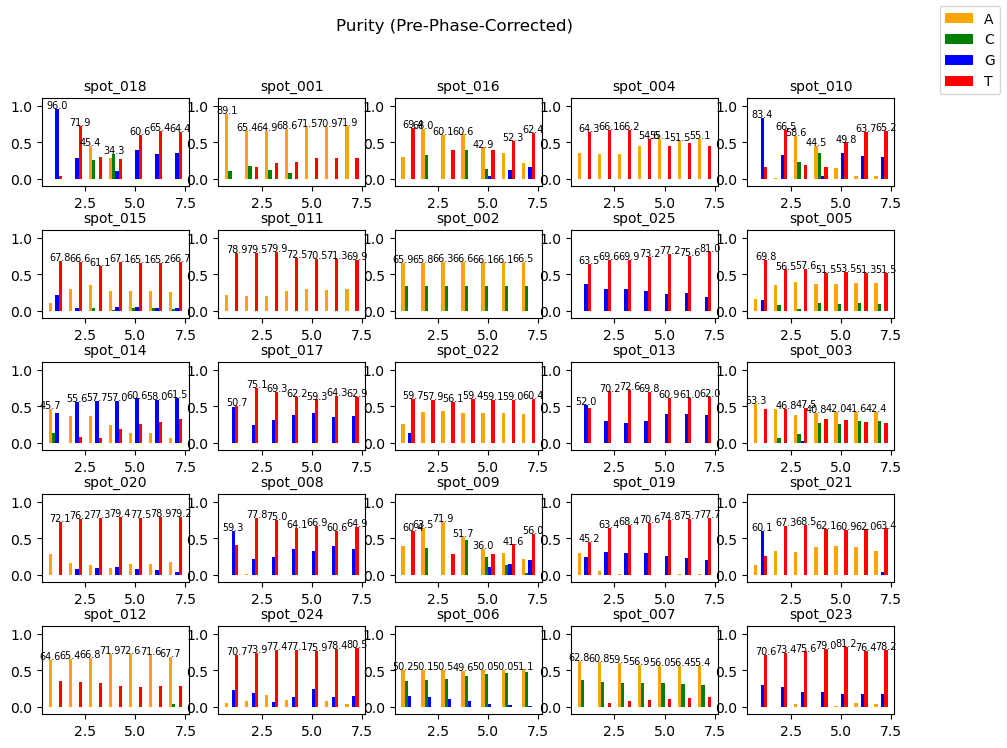

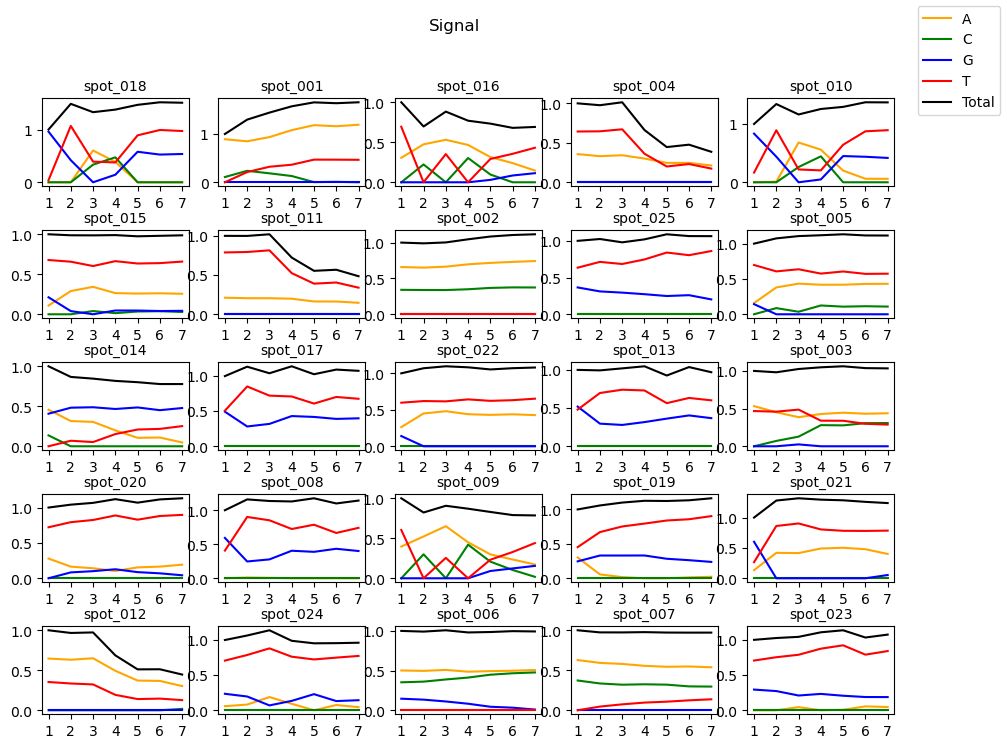

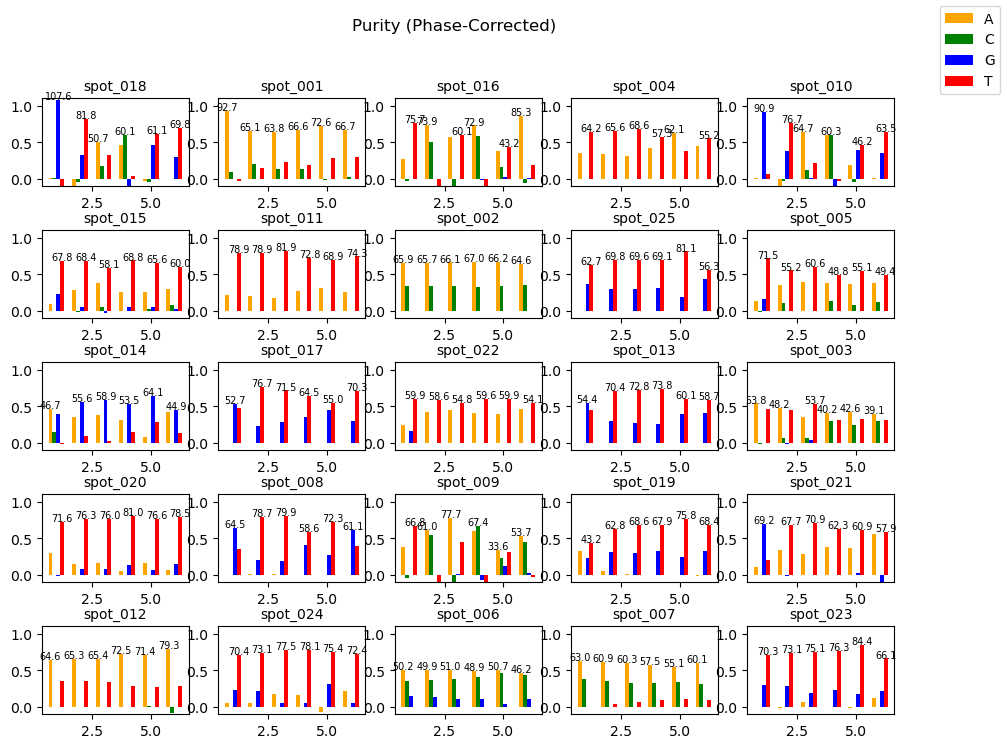

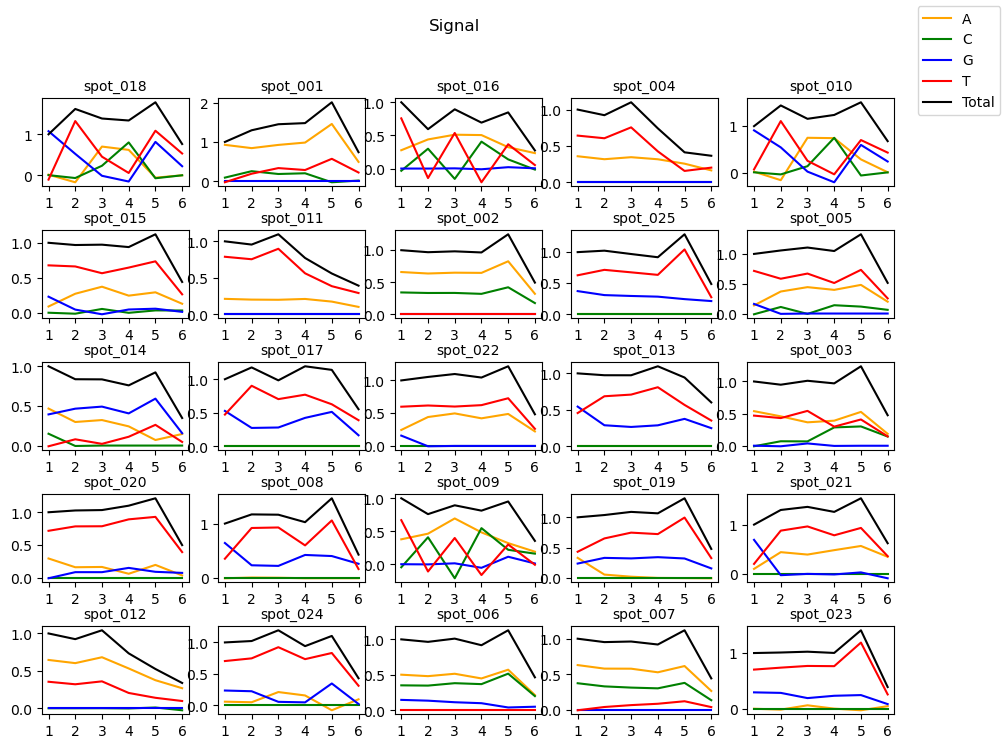

In [23]:
# You can name report file here:
reportfile = os.path.join(input_dir_path, "report.txt")

figNumRows = 5

#TODO: spot name lookup table

#### DO NOT EDIT BELOW THIS LINE ####
f1, f2 = display_signals(signal_pre_basecall, spotlist, numCycles, numRows=figNumRows, preOrPost="pre")
f3, f4 = display_signals(signal_post_basecall, spotlist, numCycles-1, numRows=figNumRows, preOrPost="post")

for f_idx, f in enumerate(f1):
    f.savefig(os.path.join(input_dir_path, f"Purity Pre-Phase {f_idx+1}.png"))
for f_idx, f in enumerate(f2):
    f.savefig(os.path.join(input_dir_path, f"Signal Pre-Phase {f_idx+1}.png"))
for f_idx, f in enumerate(f3):
    f.savefig(os.path.join(input_dir_path, f"Purity Post-Phase {f_idx+1}.png"))
#for f_idx, f in enumerate(f4):
#    f.savefig(os.path.join(input_dir_path, f"Signal Post-Phase {f_idx+1}.png"))

#TODO add more metrics to report
#TODO package up as pdf?    

with open(reportfile, 'w') as f:
    if useDifferenceImage:
        print(f"Difference = Temporal", file=f)
    else:
        print(f"Difference = Dark", file=f)

    print(f"Median Filter Kernel Size = {median_kernel_size}", file=f)
    print(f"Erosion Kernel Size = {erode_kernel_size}", file=f)
    print(f"Dilation Kernel Size = {dilate_kernel_size}", file=f)
    print(f"Mean Threshold Scale Factor = {threshold_scale}", file=f)
    print(f"ROI labels at {os.path.join(input_dir_path, 'rois.jpg')}", file=f)
    print(f"'Cross-talk' matrix M = {M}", file=f)
    #todo list where output csv is?
    print(f"Pre-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Pre-Phase.png')}", file=f)
    print(f"Pre-phase corrected Signal {os.path.join(input_dir_path, 'Signal Pre-Phase.png')}", file=f)
    print(f"Base-caller p = {p}", file=f)
    print(f"Base-caller q = {q}", file=f)
    print(f"Post-phase corrected Purity at {os.path.join(input_dir_path, 'Purity Post-Phase.png')}", file=f)
    print(f"Post-phase corrected Signal {os.path.join(input_dir_path, 'Signal Post-Phase.png')}", file=f)